# Zillow Regression Project
#### Robert Murphy
##### June 14,2021

-----------------------

## Project Planning

- Create a README.md which contains a data dictionary, project objectives, business goals, initial hypothesis.
- Acquire the zillow dataset from the Codeup databse, create a function which will use a sql query and pull specific tables save this function in a acquire.py
- Prep the zillow dataset and clean it as well, remove unwanted data, make alterations to the datatypes.
- Change any categorical variables into a binary categorical. Create a function to simplify this process and include it in a prepare.py
- Calculate your baseline accuracy and use this for comparing adequacy of the model.
- Perform two statistical test: TTest, Pearson Correlation.
- Train two different regression models.
- Evaluate the models on the train and validate datasets.
- Choose the model which performs the best, then run that model on the test dataset.
- Present conclusions and main takeaways.





### Executive Summary:
-


# Imports:

In [1]:
import pandas as pd
import numpy as np
import os
from env import host, user, password
import seaborn as sns
from pydataset import data
import matplotlib.pyplot as plt
import math
import prepare
import acquire

from scipy import stats
import explore
import wrangle
import zillow_wrangle
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler
import decimal as d

from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.linear_model import LassoLars
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import TweedieRegressor

from sklearn.linear_model import LinearRegression, LassoLars
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error
from sklearn.metrics import explained_variance_score

# ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Acquire Stage:

### Main Objective:
- Connect to the Codeup DB and bring in the Zillow dataset

In [2]:
#created df.
zillow_df = acquire.get_zillow()
zillow_df.head()

,parcelid,bedroomcnt,bathroomcnt,calculatedfinishedsquarefeet,taxvaluedollarcnt,yearbuilt,taxamount,fips
0,11721753,3.0,2.0,1316.0,205123.0,1923.0,2627.48,6037.0
1,11289917,3.0,2.0,1458.0,136104.0,1970.0,2319.90,6037.0
2,11705026,2.0,1.0,1421.0,35606.0,1911.0,543.69,6037.0
3,14269464,4.0,3.0,2541.0,880456.0,2003.0,9819.72,6059.0
4,11446756,3.0,2.0,1491.0,107110.0,1955.0,1399.27,6037.0


In [3]:
# initial thoughts: looking at some fields which can have dummies generated, taxvalue and tax amount need to be changed to int values.  
# Fips can be changed to column stating county and state.
# initial mvp just utilizes four fields. Can change parcel id to index, use this to see if duplicate parcels in df.
zillow_df.head()

,parcelid,bedroomcnt,bathroomcnt,calculatedfinishedsquarefeet,taxvaluedollarcnt,yearbuilt,taxamount,fips
0,11721753,3.0,2.0,1316.0,205123.0,1923.0,2627.48,6037.0
1,11289917,3.0,2.0,1458.0,136104.0,1970.0,2319.90,6037.0
2,11705026,2.0,1.0,1421.0,35606.0,1911.0,543.69,6037.0
3,14269464,4.0,3.0,2541.0,880456.0,2003.0,9819.72,6059.0
4,11446756,3.0,2.0,1491.0,107110.0,1955.0,1399.27,6037.0


In [4]:
#looking into the data types. Can see also some fields contain null values.
zillow_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28418 entries, 0 to 28417
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   parcelid                      28418 non-null  int64  
 1   bedroomcnt                    28418 non-null  float64
 2   bathroomcnt                   28418 non-null  float64
 3   calculatedfinishedsquarefeet  28345 non-null  float64
 4   taxvaluedollarcnt             28417 non-null  float64
 5   yearbuilt                     28322 non-null  float64
 6   taxamount                     28417 non-null  float64
 7   fips                          28418 non-null  float64
dtypes: float64(7), int64(1)
memory usage: 1.7 MB


In [5]:
# shape of our df is 28418 records and 8 fields
zillow_df.shape

(28418, 8)

In [6]:
#### quick looks at the stat ####
# max baths and beds are 11 and 12.
# lowest taxvalue is 1000, max is 238583700
#earliest house was built in 1878.

zillow_df.describe().T

,count,mean,std,min,25%,50%,75%,max
parcelid,28418.0,1.307361e+07,3.747577e+06,10711855.00,11523237.25,12611531.0,14163710.25,1.676878e+08
bedroomcnt,28418.0,3.298086e+00,9.547586e-01,0.00,3.00,3.0,4.00,1.200000e+01
bathroomcnt,28418.0,2.311070e+00,1.017817e+00,0.00,2.00,2.0,3.00,1.100000e+01
calculatedfinishedsquarefeet,28345.0,1.931781e+03,1.013657e+03,240.00,1276.00,1669.0,2319.00,3.564000e+04
taxvaluedollarcnt,28417.0,5.332912e+05,7.063144e+05,1000.00,198412.00,380733.0,630000.00,2.385837e+07
yearbuilt,28322.0,1.963908e+03,2.307474e+01,1878.00,1950.00,1961.0,1980.00,2.016000e+03
taxamount,28417.0,6.486383e+03,8.209046e+03,51.26,2690.92,4703.7,7495.44,2.767978e+05
fips,28418.0,6.050004e+03,2.191571e+01,6037.00,6037.00,6037.0,6059.00,6.111000e+03


### Main Takeaways:
- Initial shape is 28418 records and 8 fields.
- A few of the fields contain null values.
- Looking at initial stats, seems like there is some potential outliers. 
- Implmented a sql query within a function which brings in dataframe filtered to hot months.
- Data Types are all numerical but Bedroomcnt,bathroomcnt and fips can be classified as categorical.

--------------------------------------

# Prepare Stage:

### Main Objective:

#### House cleaning.
- Changed parcelid to the index.
- Dropped duplicate values and columns.
- Found records containing empty values and replaced with NaN, then dropped the NaN.
- Converted several fields from object based binary categorical to binary utilizing numerics categorical.
- Created columns which are binned, changed the values into 0 and 1 numeric based categorical.
- Renamed several columns.
- Created a function which does the above.


In [7]:
#utilizing funcitn within prepare.py to prep data.
zillow = prepare.prep_zillow(zillow_df)

In [8]:
#renamed columns and added in additional features.
zillow.head()

,total_squareft,assessment_value,three_or_less_bedrooms,four_or_more_bedrooms,three_or_more_bathrooms,two_half_or_less_bathrooms
parcelid,,,,,,
11721753,1316.0,205123.0,1,0,1,0
11289917,1458.0,136104.0,1,0,1,0
11705026,1421.0,35606.0,1,0,0,1
14269464,2541.0,880456.0,0,1,1,0
11446756,1491.0,107110.0,1,0,1,0


In [9]:
#splitting into a train, validate and test dataset.
train, validate, test = wrangle.split_continuous(zillow)

train -> (14100, 6)
validate -> (6043, 6)
test -> (5036, 6)


### Main Takeaway:

- Doing house cleaning: dropping duplciates, dropping nans, and set parcelid to index.
- DF shape now 25179 records and 4 fields
- Calculated outliers for each field, dropped these outliers.
- Made some simple charts to visualize outliers
- split the zillow df into a train, validate, test datasets.

----------------------

# Explore:

### Data Exploration

##### - Goal: univariate, bivariate, multivariate exploration. 
##### - Two statistical analysis.
##### - Target assessment_value  is continuous, this is a regression problem.

----------------------------------------------


In [10]:
#Specifiying quantative and categorical features
cat_vars = ['bedroomcnt', 'bathroomcnt','three_or_less_bedrooms', 'four_or_more_bedrooms', 'three_or_more_bathrooms', 'two_half_or_less_bathrooms']
quant_vars = ['total_squareft','assessment_value']

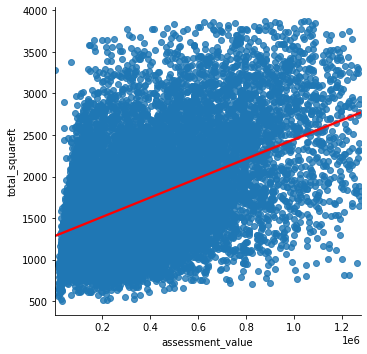

In [11]:
# there isnt really a great visible trend, an assumption can be made whiich as totalsquareft increase assessment_value increases.
sns.lmplot(x = 'assessment_value', y = 'total_squareft' , data = train, line_kws={'color': 'red'})

### Lmplot Main Takeaway:

- With the amount of data within the DF, the chart is very cluttered with points. You can barely make out a trend which shows as total square ft increase so does the assessment value.
- This makes sense, the larger the square footage the greater the cost of the house. However this can be misleading without additional information. Areas can deplete a homes value even if the house is larger and also the age can result in a larger house value also being less. So remember to keep this in mind.

<AxesSubplot:xlabel='two_half_or_less_bathrooms', ylabel='assessment_value'>

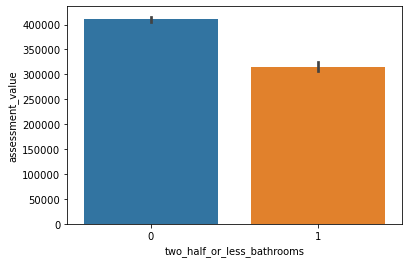

In [12]:
# can see that the tow and half baths or less have the max assessment_value
sns.barplot(x='two_half_or_less_bathrooms', y='assessment_value', data=train)

<AxesSubplot:xlabel='three_or_less_bedrooms', ylabel='assessment_value'>

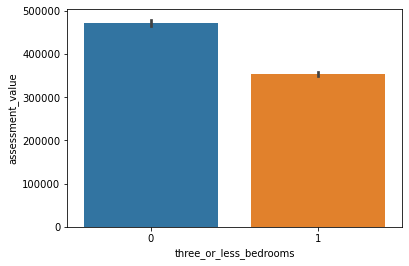

In [13]:
#greater than 3 bedrooms have the max assessment value.
sns.barplot(x='three_or_less_bedrooms', y='assessment_value', data=train)

#### Barplot takeaways:
- Can clearly see there is a relatiinship between the number bedrooms and assessment value. 
- The same can be interpreted by examining bathroom count within a home, those who do not have 2.5 baths or less had higher assessment values.
    

### Utilizing Heat Map to see which features correlate strongest with the target (assessment_value)

<AxesSubplot:title={'center':'Feautures  Correlating with assessment_value'}>

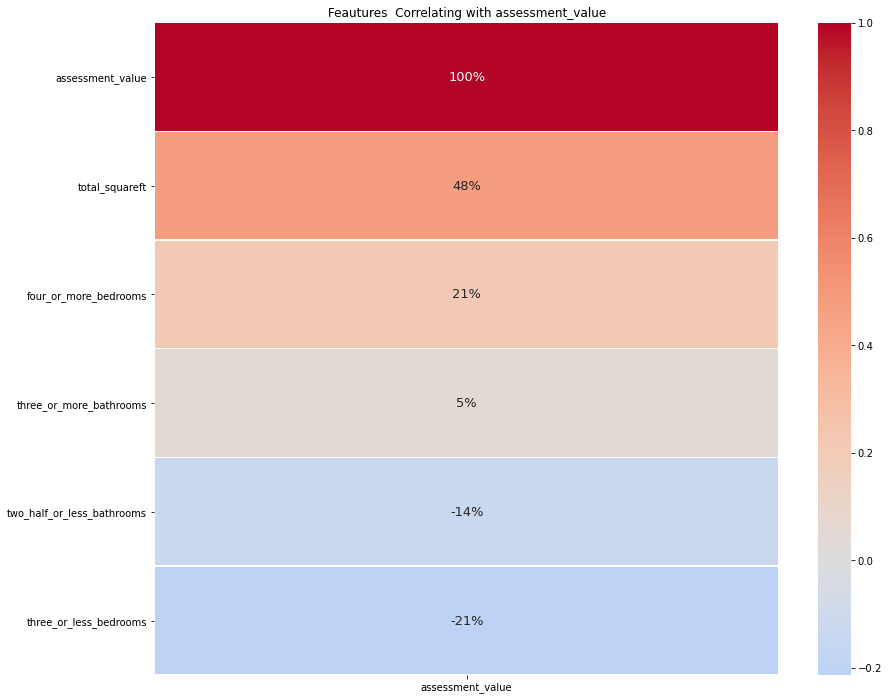

In [14]:
#strongest correlation is total_squareft, four or more bedrooms, three or more bathrooms
explore.get_heatmap(train, 'assessment_value')

## Statistical Tests / Hypothesis Testing:

- Hypothesis Null1: There is no relationship between the square footage of a house and assessment value. Possibly as square foot increase so does the assessment value. Contin vs contin Correlation Test.
- Hypothesis Null2: There is no difference in the assessment values for those who have four or more bedrooms than those who dont. Categorical and continous 


 Pearson correlation coefficient is 0.48091471407251496, the corresponding p value is 0.0.
 We reject the null, and accept HA: there is a relationship between total_squareft and assessment_value


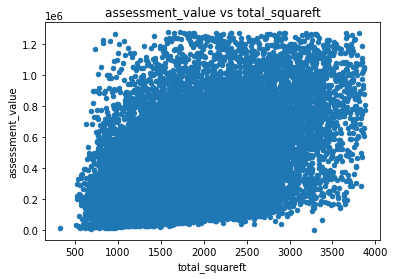

In [43]:
#Pearson Correlation

## Null: There is no relationship between the square footage of a house and assessment value. 
   
alpha = 0.05

corr, p = stats.pearsonr(zillow.total_squareft, zillow.assessment_value)
print(f' Pearson correlation coefficient is {corr}, the corresponding p value is {p}.')


zillow.plot.scatter('total_squareft', 'assessment_value')
plt.title('assessment_value vs total_squareft')

if p < 0.05:
    print(' We reject the null, and accept HA: there is a relationship between total_squareft and assessment_value')
else:
    print(' We accept null there is no relationship between total_squareft and assessment_value')


In [44]:
#TTest
# make a subset 
x1 = train[train.four_or_more_bedrooms == 1].assessment_value
x2 = train[train.four_or_more_bedrooms == 0].assessment_value


# run a 2 sample, 2 tail t-test
t_stat, p = stats.ttest_ind(x1, x2)

print(f'\nstatistic = {t_stat:.4f}')
print(f'p_value = {p:.4f}')

# set alpha
alpha = 0.05

null_hypothesis = "There is no difference in the assessment values for those who have four or more bedrooms than those who dont."

if p < alpha:
    print(f'\nWe can reject the null hypothesis that', null_hypothesis)
else:
    print(f'\nWe fail to reject the null hypothesis.')


statistic = 25.9369
p_value = 0.0000

We can reject the null hypothesis that There is no difference in the assessment values for those who have four or more bedrooms than those who dont.


<AxesSubplot:xlabel='four_or_more_bedrooms', ylabel='assessment_value'>

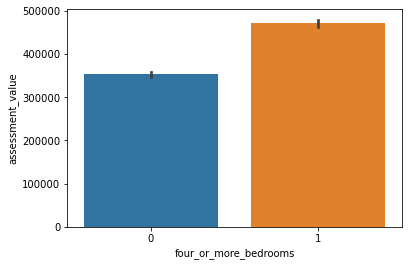

In [17]:
sns.barplot(x='four_or_more_bedrooms', y='assessment_value', data=train)

### Main Takeaways:
- Heat mapp indicates correlations are fairly decent. Going to utilize 5 features within the model.
- We rejected the Null hypothesis for each test.
- There is a difference in assessment values for those who have homes with >= 4 bedrooms.
- Based on the pearson coefficent and p value, we can say that there is a relationship between totalsquare_ft and assessment_value.


--------------------------

# Modeling:

#### About the initial baseline:

- 1.) Need to know how well we can estimate (predict) the assessment_value without using any features. Need to look at the mean or the median. 
- 2.) Try both the mean and the median, see which performs best, and set that evaluation metric value as our baseline performance to beat.


In [21]:
#Seperating into features and target to run models. 
X_train, y_train, X_validate, y_validate, X_test, y_test = zillow_wrangle.train_validate_test(zillow, 'assessment_value', None)

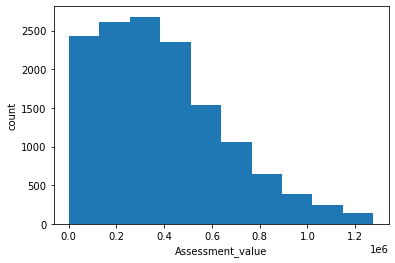

In [22]:
# Skewed right but observations greater than 30 and within 4000 dollars of each.
plt.hist(y_train)
plt.xlabel("Assessment_value")
plt.ylabel("count")
plt.show()

In [23]:
# mean and median are farily similar.
y_train.mean(), y_train.median()

(393959.19141843973, 350085.0)

### Deciding wether to utilize mean or median for the baseline

In [24]:
# y_train and y_validate have to be dataframes to append the new columns with predicted values. 
y_train = pd.DataFrame(y_train)
y_validate = pd.DataFrame(y_validate)

# 1. Predict assessment_value_pred_mean
assessment_value_pred_mean = y_train.assessment_value.mean()
y_train['assessment_value_pred_mean'] = assessment_value_pred_mean 
y_validate['assessment_value_pred_mean'] = assessment_value_pred_mean 

# 2. compute assessment_value_pred_median
assessment_value_median = y_train.assessment_value.median()
y_train['assessment_value_median'] = assessment_value_median
y_validate['assessment_value_median'] = assessment_value_median

# 3. RMSE of assessment_value_pred_mean
rmse_train = mean_squared_error(y_train.assessment_value, y_train.assessment_value_pred_mean) ** 0.5
rmse_validate = mean_squared_error(y_validate.assessment_value, y_validate.assessment_value_pred_mean) ** 0.5

print("RMSE using Mean\nTrain/In-Sample: ", round(rmse_train, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 2))

RMSE using Mean
Train/In-Sample:  263663.92 
Validate/Out-of-Sample:  263244.25


In [25]:
# 4. RMSE of assessment_pred_median
rmse_train = mean_squared_error(y_train.assessment_value, y_train.assessment_value_median) ** .5
mse_validate = mean_squared_error(y_validate.assessment_value, y_validate.assessment_value_median) ** .5
print("RMSE using Median\nTrain/In-Sample: ", round(rmse_train, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 2))

RMSE using Median
Train/In-Sample:  267289.37 
Validate/Out-of-Sample:  263244.25


### Baseline Prediction

In [27]:
# Baseline prediction will utilize mean, RMSE value for mean was better than median.
# Have stated our baseline accuracy for the model to beatr in order to be considered valid.
baseline = y_train.assessment_value.mean()
y_train['baseline'] = baseline

In [28]:
# Baseline RMSE calculation.
baseline_RMSE = math.sqrt(mean_squared_error(y_train.assessment_value, y_train.baseline))
print(f'Train RMSE Baseline {baseline_RMSE}.')

Train RMSE Baseline 263663.9232487312.


### Model 1: Linear Regression

In [35]:
# create the model object
linear_model = LinearRegression(normalize=True)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
linear_model.fit(X_train, y_train.assessment_value)

# predict train
y_train['assessment_value_predict_lm'] = linear_model.predict(X_train)

# evaluate: rmse
rmse_train_lr = mean_squared_error(y_train.assessment_value, y_train.assessment_value_predict_lm)**(1/2)

# predict validate
y_validate['assessment_value_predict_lm'] = linear_model.predict(X_validate)

# evaluate: rmse
rmse_validate_lr = mean_squared_error(y_validate.assessment_value, y_validate.assessment_value_predict_lm)**(1/2)

print("RMSE for OLS using LinearRegression\nTraining/In-Sample: ", rmse_train_lr, 
      "\nValidation/Out-of-Sample: ", rmse_validate_lr)
evs_lr = explained_variance_score(y_train.assessment_value, y_train.assessment_value_predict_lm)
print('Explained Variance Linear Regression Model = ', round(evs_lr,3))

RMSE for OLS using LinearRegression
Training/In-Sample:  230956.06167951802 
Validation/Out-of-Sample:  227968.27728868957
Explained Variance Linear Regression Model =  0.233


#### Linear_regression takeaway:
- The RMSE values for the training and validate differ by ~$3000.00
- So due to the RMSE value representing dollars, I feel comfortable in saying this is an exceptable model.
- Train out performed the baseline, as did the validate, so the model is valid and useful in predicting assessment value.

### Model 2 : Polynomial

In [31]:
# make the polynomial features to get a new set of features
poly_feat = PolynomialFeatures(degree=3)

# fit and transform X_train
X_train_degree3 = poly_feat.fit_transform(X_train)

# transform X_validate & X_test
X_validate_degree3 = poly_feat.transform(X_validate)
X_test_degree3 = poly_feat.transform(X_test)

y_test.shape, X_test.shape, X_test_degree3.shape

((5036,), (5036, 5), (5036, 56))

In [32]:
# create the model object
linear_model3 = LinearRegression(normalize=True)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
linear_model3.fit(X_train_degree3, y_train.assessment_value)

# predict train
y_train['assessment_predict_linear_model3'] = linear_model3.predict(X_train_degree3)

# evaluate: rmse
rmse_train_poly = mean_squared_error(y_train.assessment_value, y_train.assessment_predict_linear_model3)**(1/2)

# predict validate
y_validate['assessment_predict_linear_model3'] = linear_model3.predict(X_validate_degree3)

# evaluate: rmse
rmse_validate_poly = mean_squared_error(y_validate.assessment_value, y_validate.assessment_predict_linear_model3)**(1/2)

print("RMSE for Polynomial Model, degrees=3\nTraining/In-Sample: ", rmse_train_poly, 
      "\nValidation/Out-of-Sample: ", rmse_validate_poly, 
      "\nBaseline RMSE value is ", baseline_RMSE)
evs_poly = explained_variance_score(y_train.assessment_value, y_train.assessment_predict_linear_model3)
print('Explained Variance Polynomial Model = ', round(evs_poly,3))

RMSE for Polynomial Model, degrees=3
Training/In-Sample:  230803.69804472508 
Validation/Out-of-Sample:  227951.14520817724 
Baseline RMSE value is  263663.9232487312
Explained Variance Polynomial Model =  0.234


#### Polynomial Model Takeaway:
    
- Polynomial performed same as regression
- Model doesnt appear to be overfit.
- Model performed better than the baseline.

### Model 3: Lasso Lars 

In [41]:
# create the model object
lars_model = LassoLars(alpha=1.0)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lars_model.fit(X_train, y_train.assessment_value)

# predict train
y_train['assessment_value_prediction_lars'] = lars_model.predict(X_train)

# evaluate: rmse
rmse_train_lars = mean_squared_error(y_train.assessment_value, y_train.assessment_value_prediction_lars)**(1/2)

# predict validate
y_validate['assessment_value_prediction_lars'] = lars_model.predict(X_validate)

# evaluate: rmse
rmse_validate_lars = mean_squared_error(y_validate.assessment_value, y_validate.assessment_value_prediction_lars)**(1/2)

print("RMSE for Lasso + Lars\nTraining/In-Sample: ", rmse_train_lars, 
      "\nValidation/Out-of-Sample: ", rmse_validate_lars,
      "\nBaseline RMSE value is ", baseline_RMSE)
evs_lars = explained_variance_score(y_train.assessment_value, y_train.assessment_value_prediction_lars)
print('Explained Variance Linear Regression Model = ', round(evs_lars,3))

RMSE for Lasso + Lars
Training/In-Sample:  230956.70021901326 
Validation/Out-of-Sample:  227978.63911303616 
Baseline RMSE value is  263663.9232487312
Explained Variance Linear Regression Model =  0.233


### Lasso Lars Model Takeaway:
    
- Lasso lars performed the worst out of every model
- The model did perform better than the baseline so it is valid.

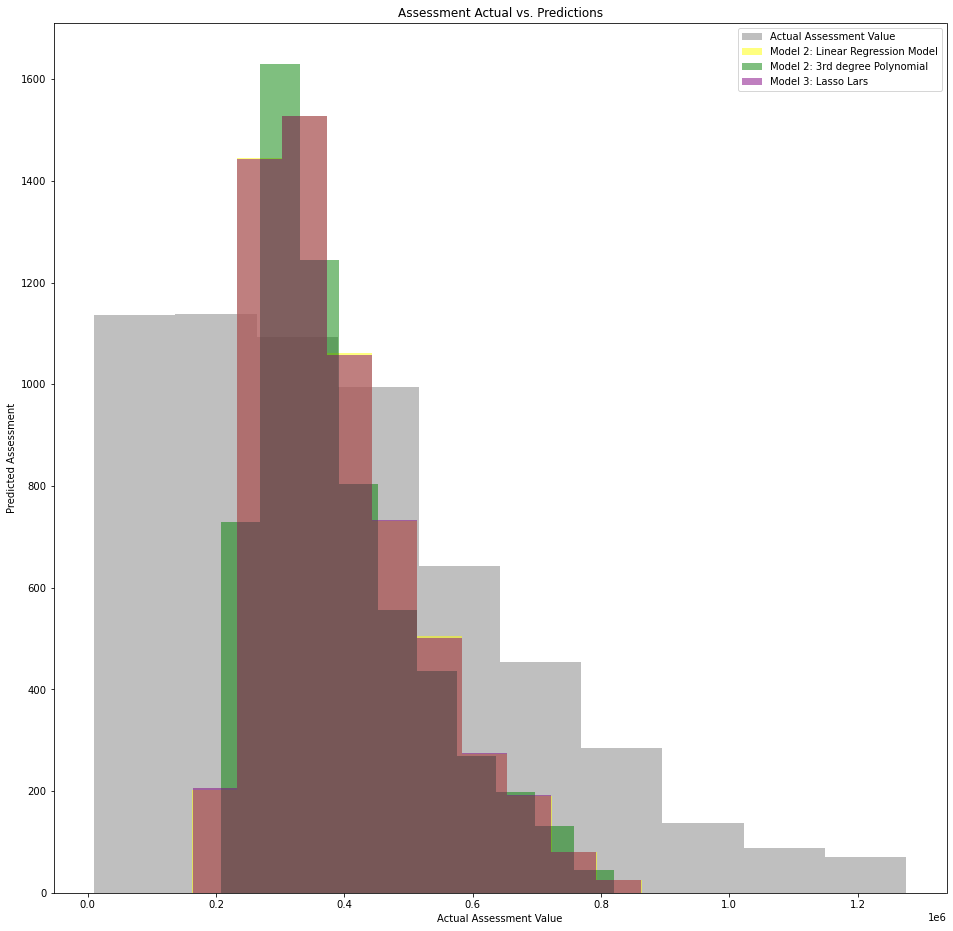

In [38]:
# plot to visualize actual vs predicted. 
plt.figure(figsize=(16,16))
plt.hist(y_validate.assessment_value, color='grey', alpha=.5, label="Actual Assessment Value")
plt.hist(y_validate.assessment_value_predict_lm, alpha=.5, color="yellow", label="Model 2: Linear Regression Model")
plt.hist(y_validate.assessment_predict_linear_model3, alpha=.5, color="green", label="Model 2: 3rd degree Polynomial")
plt.hist(y_validate.assessment_value_prediction_lars, alpha=.5, color="purple", label="Model 3: Lasso Lars ")
plt.xlabel("Actual Assessment Value")
plt.ylabel("Predicted Assessment")
plt.title("Assessment Actual vs. Predictions")
plt.legend()
plt.show()

#### Histo Chart Takeaway:
- The main takeaway is that polynomial is the closer fit to the actual compared to other models. 

### MVP Model Takeaways: 
- Polynomial model performed better than lasso lars and regression. Ploynomial also performed better than the baseline so the model is viable.

# Evaluate On Test Dataset:

--------------------

In [39]:
# create the model object
# predict train
# create dataframe
y_test = pd.DataFrame(y_test)
# use the model to make predictions
y_test['assessment_predict_poly_test'] = linear_model3.predict(X_test_degree3)

# evaluate: rmse
rmse_test_poly = mean_squared_error(y_test.assessment_value, y_test.assessment_predict_poly_test)**(1/2)


print("\nTest/Out-of-Sample: ", rmse_test_poly,
      "\nBaseline RMSE value is ", baseline_RMSE)
evs_poly_test = explained_variance_score(y_test.assessment_value, y_test.assessment_predict_poly_test)
print('Explained Variance Polynomial Model = ', round(evs_poly_test,3))





Test/Out-of-Sample:  229734.06061287798 
Baseline RMSE value is  263663.9232487312
Explained Variance Polynomial Model =  0.245


--------------------------

# Conclusions:

#### - Using select features to predict the assessment value of single unit properties during May 2017- Aug 2017.
#### - Utilized 5 features within model to predict assessment value.
#### - Polynomial Model had lowest validate RMSE value: 227951.14 and performed better than the baseline RMSE value: 263663.92, so evaluated the test dataset using this model.
#### - Evaluted model on test dataset, model performed better than the baseline.


-----------------------------------

## Other Deliverables:

#### TAX RATE:

In [42]:
#calculate TAX RATE
zillow_df['tax_rate'] = zillow_df['taxamount']/zillow_df['taxvaluedollarcnt']
zillow_df.fips.value_counts()

6037.0    17962
6059.0     7773
6111.0     2683
Name: fips, dtype: int64

#### FIPS County Name

In [46]:

#Need to create columns which have state name and county name from the fips column.
zillow_df['county_name'] = zillow_df['fips'].map({6037:'Los Angeles', 6059:'Orange', 6111:'Ventura'})
zillow_df.county_name.value_counts()

Los Angeles    17962
Orange          7773
Ventura         2683
Name: county_name, dtype: int64

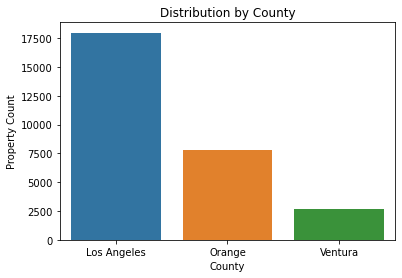

In [47]:
plt.title('Distribution by County')
sns.countplot(zillow_df.county_name)
plt.xlabel('County')
plt.ylabel('Property Count')
plt.show()

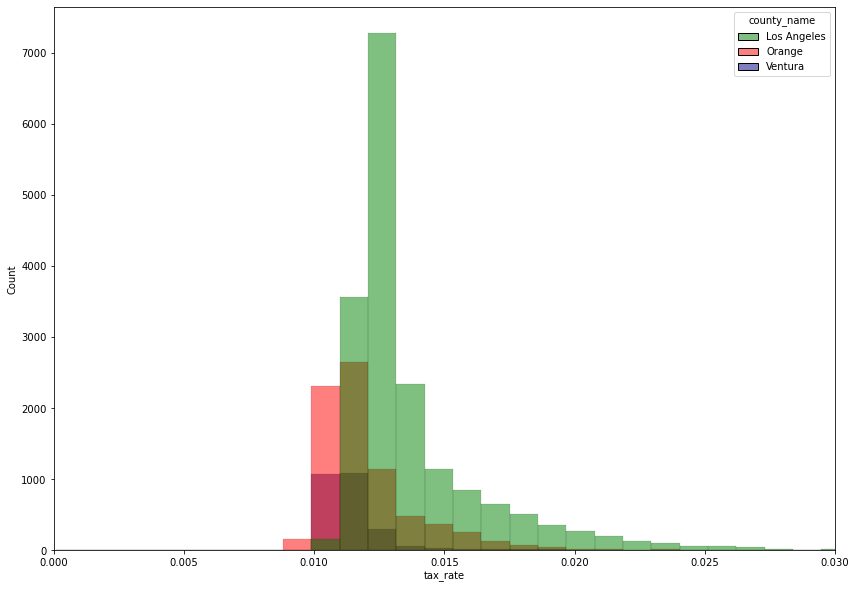

In [48]:
#Distiribution of Tax Rate by County
plt.figure(figsize=(14,10))
sns.histplot(data=zillow_df, x="tax_rate", hue="county_name",kde = False, bins = 750,  palette={'Orange':'red', 'Los Angeles':'green', 'Ventura':'navy'})
plt.xlim(0, 0.03)
plt.show()

<AxesSubplot:xlabel='county_name', ylabel='tax_rate'>

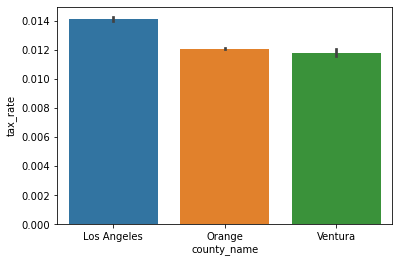

In [49]:
sns.barplot(data = zillow_df, x ='county_name', y = 'tax_rate')